<a href="https://colab.research.google.com/github/kiwibird35/geogfiles/blob/main/Copy_of_kd_tree_querying_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/gisalgs/notebooks/blob/main/kd-tree-querying-colab.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Range Query Using k-D Trees


So far we have discussed how to query a k-D tree for a point. We can use k-D trees to conduct more complicated queries. For example, we can use a k-D tree to efficiently find all the points in a certain region such as a circle or rectangle and we call this a **range query**. We can also find a specified number of the nearest points of a given point. We will focus on a particular query called **orthogonal range query**, where the range is specified as a rectangle. There are other kinds of queries, including circular range query and nearest neighbor query. More details can be found in the textbook *GIS Algorithms* and the code are available in the [indexing repository](https://github.com/gisalgs/indexing) at the github site.

## Orthogonal range query: a brute force approach

Given a **rectangle**, can we quickly find all the points that fall within the rectangle? A brute-force approach is to test every point. We can also call it exhaustive search since it exhausts all the possible cases. This is straightforward to implement, but it can be extremely slow, especially when we have a lot of points to test and we have to test many times -- think about the number of places in the world.

To show how a brute force approach works, we will complete the code below. Here, we encode the rectangle as a list of lists of four values: `[[xmin, xmax], [ymin, ymax]]`.

In [ ]:
# assume: geom and indexing are already installed (shell) or cloned (notebook)
#         and the path is set (for shell only)
!git clone https://github.com/gisalgs/indexing.git
!git clone https://github.com/gisalgs/geom.git

Cloning into 'indexing'...
remote: Enumerating objects: 170, done.
remote: Total 170 (delta 0), reused 0 (delta 0), pack-reused 170
Receiving objects: 100% (170/170), 33.41 KiB | 1.45 MiB/s, done.
Resolving deltas: 100% (92/92), done.
Cloning into 'geom'...
remote: Enumerating objects: 314, done.
remote: Total 314 (delta 0), reused 0 (delta 0), pack-reused 314
Receiving objects: 100% (314/314), 57.03 KiB | 1.21 MiB/s, done.
Resolving deltas: 100% (177/177), done.


## <font color="red">Question 1</font>

Please complete the TODO part below and run the code cell.

In [ ]:
from geom.point import *

in_rect = lambda x, y, rect: not (rect[0][0]>x or rect[0][1]<x or rect[1][0]>y or rect[1][1]<y)

def search_all(all_points, rect):
    '''
    Returns the points that fall in a rectangle

    all_points    a list of Point objects
    rect          a rectangle encoded as  [[xmin, xmax], [ymin, ymax]]
    '''
    # TODO:
    #    Replace the pass statement below to complete the code for a brute-force search
    #
    found = []
    for d in my_points:
      if in_rect(d.x, d.y, rect):
        found.append(d)
    return found


# testing
raw_coord = [ (2,2), (0,5), (8,0), (9,8), (7,14), (13,12), (14,13) ]
my_points = [Point(d[0], d[1]) for d in raw_coord]
rect = [ [10, 14.5], [10, 13.5] ]

found = search_all(my_points, rect)
found



[Point(13, 12), Point(14, 13)]

### Orthogonal range query: using k-D trees

Given what we have discussed about a tree structure, we should expect a k-D tree can help with range query. We will use the following figure to explain the algorithm.

<img src="https://github.com/gisalgs/notebooks/blob/main/figures/kdtree-range-query-2.png?raw=1" width=450/>

Here we discuss a search algorithm that is detailed in a function called `range_query_orthogonal` as listed below. This function was saved in a file called **kdtree2a.py** and is available in the github site at [here](https://github.com/gisalgs/indexing/blob/master/kdtree2a.py). In this function, we use a list called `found` to hold points found by the search process. The list `found` must be declared outside and passed to the function.

![](https://github.com/gisalgs/notebooks/blob/main/figures/kd-tree-orth-query-code.png?raw=1)

The function `range_query_orthogonal` can be broken down into 5 logical blocks and we explain each of them below.

(1) We make sure that the node is not empty. We will get the situation of `t` is `None` when we travel down from a leaf node. When this happens, we know there is nothing there to check out and we will just return, meaning exist the function.

(2) If we ever reach here, it means that `t` is a valid node. Here we get which dimension we should use given the depth. The value of depth is passed from the function call and we will increase the depth value if we go down the tree (see below).

(3) If the point at node `t` is to the left or below the rectangle (depending on which dimension we are using, X or Y here), we will only need to check the right branch of the node. In order to do that, we use the same function one more time, but this time we set the node to be checked to be `t.right` and increase the depth by 1. Note that we are not going to call the function using the left branch, meaning we will exclude everything in that branch. After this is done, we will exist the function, meaning we will not run anything underneath this part.

(4) This is the code that handles the situation when the point on the node is to the right or above the rectangle.

(5) If we reach here, it means that the point on the node is sandwiched between the two bounds (either X or Y, depending on the depth of the node). There are a few things to take care of. First, we check if the point is in the rectangle, if it is then we append the point on the node (`t.point`) to the list called `found`, which will collect all points found. Second, we will have to use both the right and left branches of the node.

Once we have a good understanding of the code, it is time to first test the algorithm using the k-D tree we drew manually from the previous modules. Then we will set up a few points and use the following code to test the orthogonal range query on a k-D tree.

Again, the code of this algorithm is in the file called [kdtree2a.py](https://github.com/gisalgs/indexing/blob/master/kdtree2a.py) on github. We should download it and put it in the indexing folder, along with other files like `kdtree1.py` and `bst.py` as we have used before.

In [ ]:
from indexing.kdtree1 import *
from indexing.kdtree2a import *
from indexing.bst import *

data1 = [ (2,2), (0,5), (8,0), (9,8), (7,14), (13,12), (14,13) ]
points = [Point(d[0], d[1], 0) for d in data1]

t1 = kdtree2(points)
tree_print(t1)

rect = [ [10, 14.5], [10, 13.5] ]
found = []
range_query_orthogonal(t1, rect, found)
print()
print('Found:', found)


       ____(8, 0)____         
      /              \        
   (0, 5)         (13, 12)    
   /     \        /      \    
(2, 2) (7, 14) (9, 8) (14, 13)
/    \ /     \ /    \ /      \

Found: [Point(13, 12), Point(14, 13)]


## Validating the code

We can use the functions in matplotlib to test if the query function actually returns the right result. We will use the following couple of functions to draw points and lines.



In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def draw_points(pts, color, marker, size, alpha=0.7):
    axis = plt.scatter([p.x for p in pts], [p.y for p in pts],
                       marker=marker, color=color, s=size, alpha=alpha)
    return axis

def draw_lines(linesxy):
    frame = plt.gca()
    l = plt.Line2D(linesxy[0], linesxy[1], color='red')
    frame.add_line(l)

Now we illustrate the results.

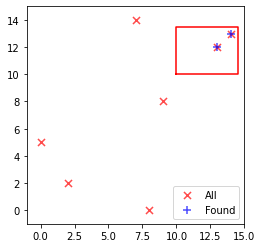

In [ ]:
data1 = [ (2,2), (0,5), (8,0), (9,8), (7,14), (13,12), (14,13) ]

points = [Point(d[0], d[1]) for d in data1]
t2 = kdtree2(points)

rect = [ [10, 14.5], [10, 13.5] ]

found = []
range_query_orthogonal(t2, rect, found)

linesXY = [ [rect[0][0], rect[0][1], rect[0][1], rect[0][0], rect[0][0]],
            [rect[1][0], rect[1][0], rect[1][1], rect[1][1], rect[1][0]] ]

p1 = draw_points(points, 'red', 'x', 50)
p2 = draw_points(found, 'blue', '+', 50)
l = draw_lines(linesXY)

plt.xlim([-1, 15])
plt.ylim([-1, 15])
plt.legend([p1, p2], ['All', 'Found'],  loc=4)

ax = plt.gca()
ax.set_aspect(1)
plt.show()

## <font color="red">Question 2</font>

If we do an orthogonal range query on the tree illustrated below using the rectangle shown in dashed red lines, the result will be an empty list. What are the nodes in the tree that must be tested by the algorithm? When we say a note is tested by the algorithm, we mean the line with a comment of `test t in rect` in [kdtree2a.py](https://github.com/gisalgs/indexing/blob/master/kdtree2a.py) is called. Apparently not every point will come to this line because of the various `return` statements before the line. You can answer this question by either slightly modifying the query function to print out the points that come to there and run it. If you choose this approach, the rectangle can be encoded as follows:

```python
rect = [ [2, 7.5], [8.5, 11.5] ]
```

You can also answer this question using a visual examination of the following figure.

<img width="450" src="https://github.com/gisalgs/notebooks/blob/main/figures/kdtree-range-query-1.png?raw=1"/>

Please add more code/markdown cells whenever needed.

**The node that must be tested is the root node, C, (8,0)**

In [ ]:
rect = [ [2, 7.5], [8.5, 11.5] ]

found = search_all(my_points, rect)
found


[]

In [ ]:
def test():
    data1 = [ (2,2), (0,5), (8,0), (9,8), (7,14),
              (13,12), (14,13) ]
    points = [Point(d[0], d[1]) for d in data1]
    t1 = kdtree(points)
    rect = [ [2, 7.5], [8.5, 11.5] ]
    found = []
    range_query_orthogonal(t1, rect, found)
    print(found)
print(t1)
print(found)

(8, 0)
[]
